# Notebook 2: Na'vi River Journey EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [2]:
navi_posted = pd.read_csv('data/navi_posted.csv')
navi_actl = pd.read_csv('data/navi_actl.csv')

In [3]:
navi_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
navi_posted['date'] = pd.to_datetime(navi_posted['date'])
navi_posted['datetime'] = pd.to_datetime(navi_posted['datetime'])
navi_posted['day_name'] = navi_posted.day_name.astype('string')

navi_actl['date'] = pd.to_datetime(navi_actl['date'])
navi_actl['datetime'] = pd.to_datetime(navi_actl['datetime'])


# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
navi_date = navi_posted.copy()
navi_date.set_index('date', inplace=True)


navi_dt = navi_posted.copy()
navi_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = navi_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = navi_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = navi_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

navi_posted.set_index('date', inplace = True)
navi_actl.set_index('date', inplace = True)

# EDA - Na'vi River Journey

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

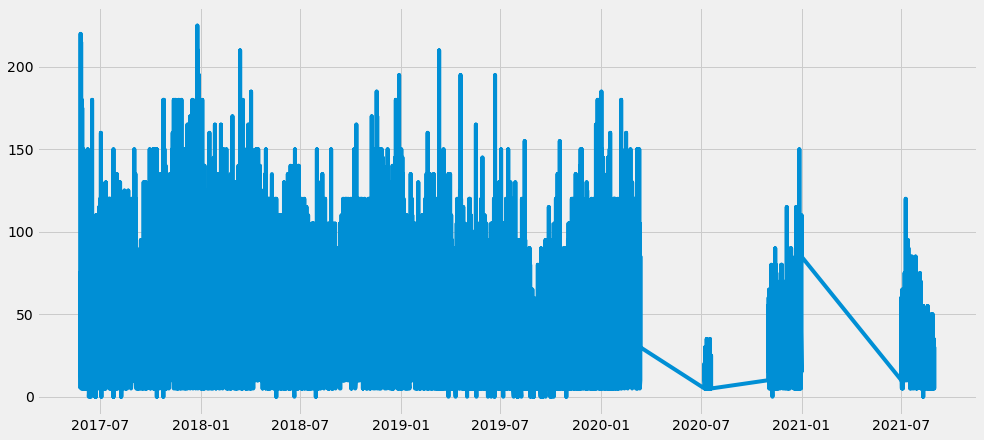

In [5]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(navi_posted['SPOSTMIN']);

In [6]:
print(f"Minimum Wait: {navi_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {navi_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 225.0


Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" will be defined as prior to January 1, 2019.

In [7]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26
1,2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday,2017-05-26
2,2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday,2017-05-26
3,2017-05-26,2017-05-26 09:30:10,NaN,45.0,5,Friday,2017-05-26
4,2017-05-26,2017-05-26 09:45:32,NaN,45.0,5,Friday,2017-05-26


In [8]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2020-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,15.0,5,Friday,2017-05-26,38.896104
2017-05-27,2017-05-28 00:59:09,NaN,30.0,6,Saturday,2017-05-27,149.453125
2017-05-28,2017-05-29 00:59:05,NaN,25.0,7,Sunday,2017-05-28,115.821429
2017-05-29,2017-05-30 00:52:10,NaN,20.0,1,Monday,2017-05-29,103.867188
2017-05-30,2017-05-31 00:52:05,NaN,15.0,2,Tuesday,2017-05-30,92.500000


In [9]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,45.0,2,Tuesday,2019-07-16,74.019608
2019-07-17,2019-07-17 23:38:02,NaN,10.0,3,Wednesday,2019-07-17,49.824561
2019-07-18,2019-07-18 23:59:01,NaN,10.0,4,Thursday,2019-07-18,70.000000
2019-07-19,2019-07-19 21:59:02,NaN,20.0,5,Friday,2019-07-19,55.642202
2019-07-20,2019-07-20 21:59:02,NaN,15.0,6,Saturday,2019-07-20,65.752212


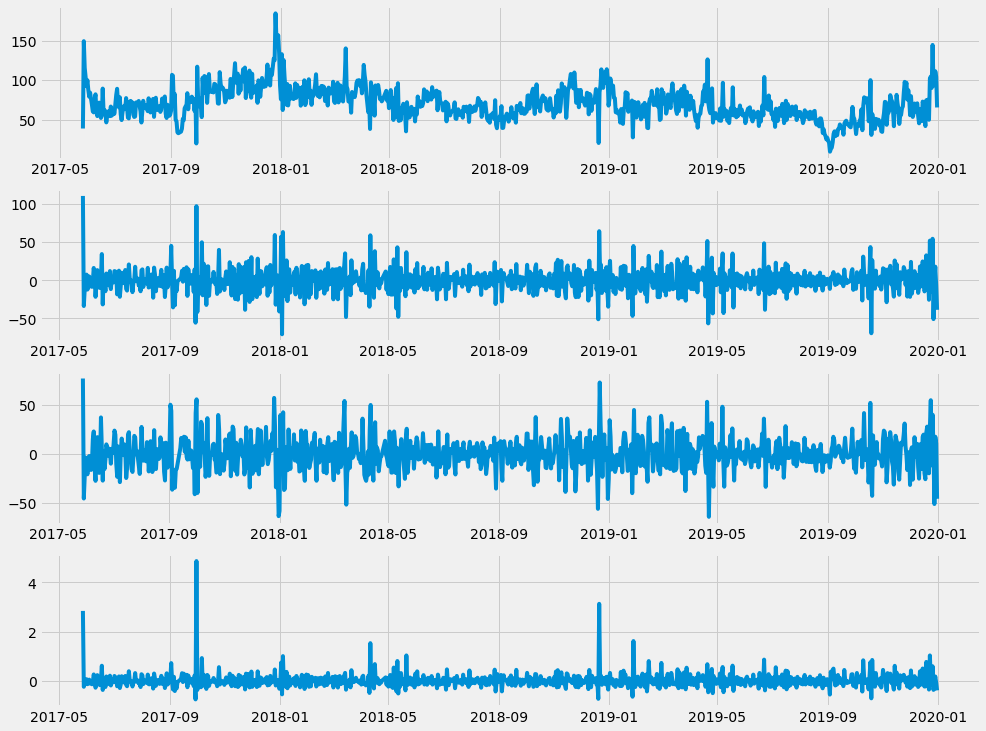

In [10]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  Note that time 0 = the day the ride opened, so that can be ignored.  But there are spikes in December, 2017 and December, 2019.  Covid might explain the lack of a spike in December, 2018.  Although the parks were open, global travel was ebbing, particularly travel from Asia.

The 4th plot (percent difference) indicates a spike in November.  This could be due to Thanksgiving as well as the beginning of summer holidays for countries in the Southern hemisphere.

Ultimately, there is some evidence of seasonality that I will investigate further in the modeling section.

Given the lack of stationarity in the plots above, and given the nature of Disney's business, I need to explore the data for hourly "seasonality," weekly "seasonality," and possibly monthly "seasonality."

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.

In [11]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       71.347767
Monday       73.393540
Saturday     73.582846
Sunday       67.281415
Thursday     71.594471
Tuesday      69.604086
Wednesday    66.131136
Name: avg_daily_wait, dtype: float64

Average daily wait time for the Na'vi River Journey was just over an hour before COVID.  Based on this summary, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 1 hour, do 8 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [12]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

navi_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
navi_Wed_Dec_05.set_index('datetime', inplace = True)

In [13]:
print(f"Minimum wait: {navi_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {navi_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 10.0
Maximum wait: 115.0


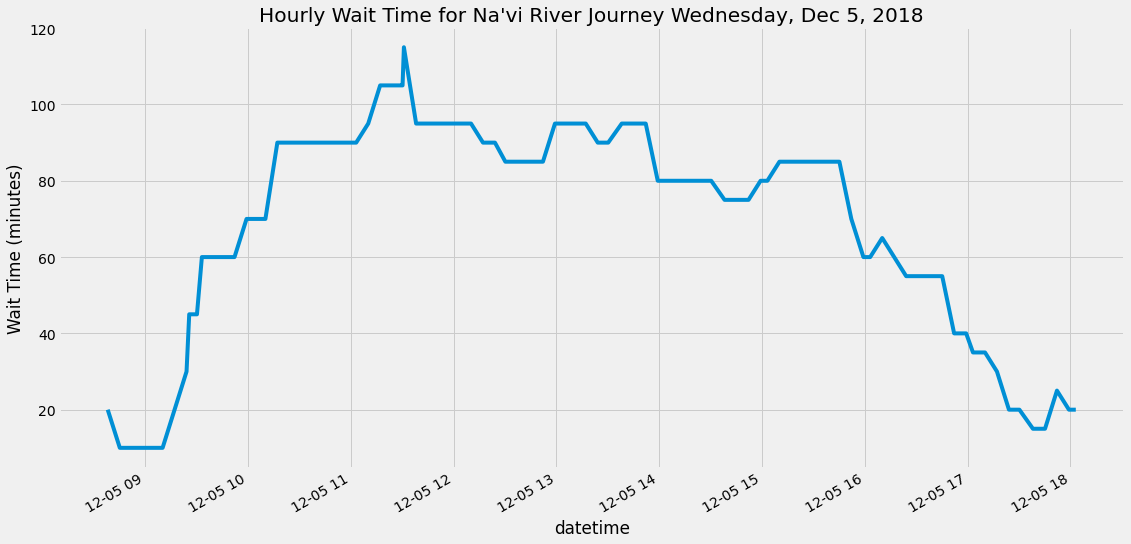

In [50]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

navi_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to purchase an individual Lightning Lane pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [15]:
# Step 3: Create data for Saturday, Dec 8, 2018

navi_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
navi_Sat_Dec_08.set_index('datetime', inplace = True)

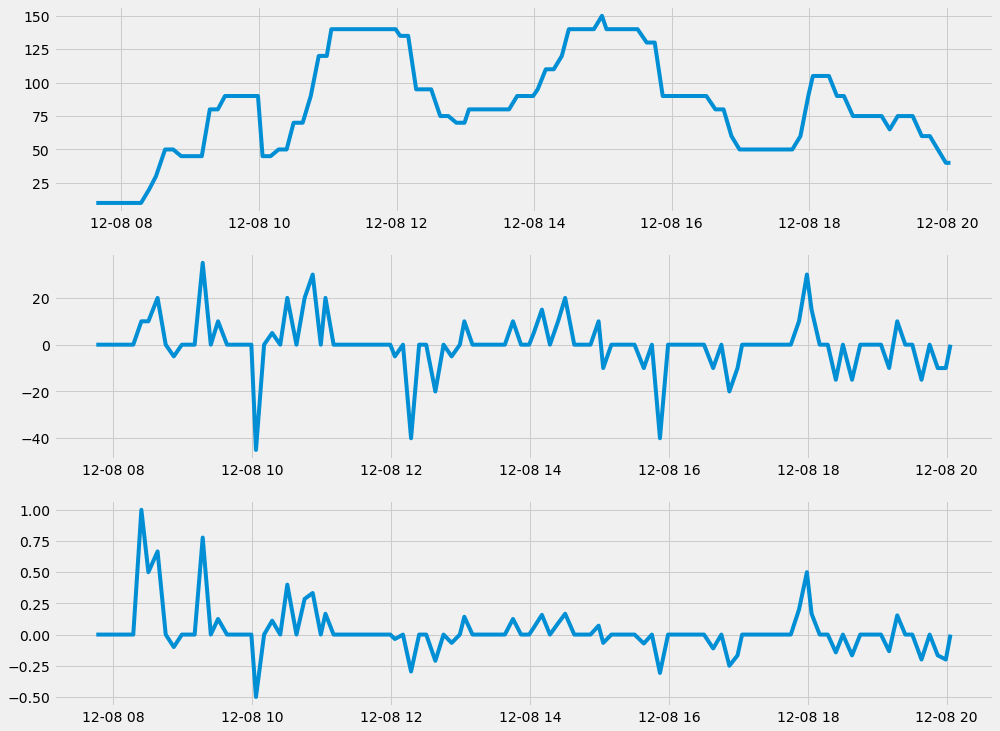

In [16]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(navi_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(navi_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(navi_Sat_Dec_08['SPOSTMIN'].pct_change());

In [17]:
print(f"Minimum wait: {navi_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {navi_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 10.0
Maximum wait: 150.0


The two hourly plots differ substantially.  The Wednesday plot shows thw wait time spiking shortly after the ride opens and remaining long until shortly before the ride closes.  The Saturday plot has several ebbs and flows, including two (around 10AM and 5-5:30PM) when the wait time drops to about 50 minutes.  Is this typical for Saturdays?  Or is this just the pattern on this particular Saturday?

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

In [18]:
# Step 5: Create df for Saturdays only
navi_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()
saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays = saturdays.groupby('date')

In [19]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
77,2017-05-27,2017-05-27 07:17:06,NaN,30.0,6,Saturday
78,2017-05-27,2017-05-27 07:24:09,NaN,20.0,6,Saturday
79,2017-05-27,2017-05-27 07:30:11,NaN,70.0,6,Saturday
80,2017-05-27,2017-05-27 07:38:05,NaN,70.0,6,Saturday
81,2017-05-27,2017-05-27 07:45:10,NaN,70.0,6,Saturday
...,...,...,...,...,...,...
112116,2019-12-28,2019-12-28 07:31:02,NaN,5.0,6,Saturday
112117,2019-12-28,2019-12-28 07:38:02,NaN,5.0,6,Saturday
112118,2019-12-28,2019-12-28 07:45:02,NaN,5.0,6,Saturday
112119,2019-12-28,2019-12-28 07:52:02,NaN,5.0,6,Saturday


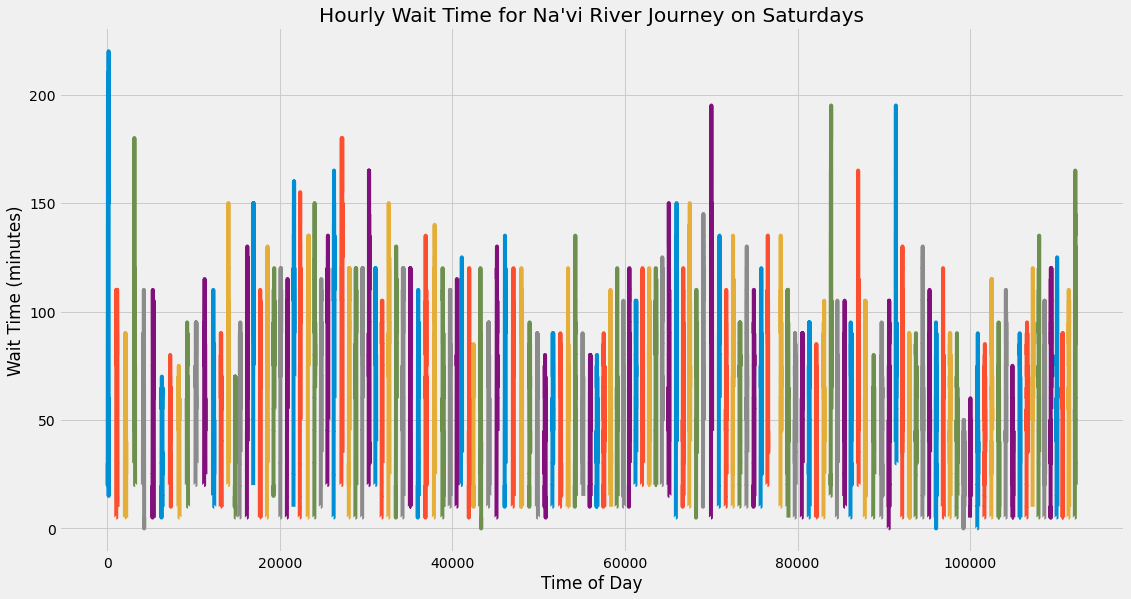

In [20]:
# Step 6: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

There might be some hourly seasonality for Saturdays, but it's very difficult to tell in this plot.  I'll revisit this in the SARIMAX model.

## Weekly Seasonality

In [21]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

precovid_weekly['week_number'] = precovid_weekly['week_num']

# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(135, 10)

In [22]:
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2017-06-01,2017-06-02 01:03:06,NaN,10.0,4,Thursday,2017-06-01,87.866667,6,0,98.343502
2017-06-08,2017-06-09 01:03:07,NaN,10.0,4,Thursday,2017-06-08,75.526316,13,1,72.110169
2017-06-15,2017-06-16 01:03:06,NaN,0.0,4,Thursday,2017-06-15,52.254902,20,2,64.533198
2017-06-22,2017-06-23 01:03:08,NaN,20.0,4,Thursday,2017-06-22,55.544872,27,3,61.076240
2017-06-29,2017-06-30 01:03:06,NaN,20.0,4,Thursday,2017-06-29,60.312500,34,4,58.719537


In [23]:
# copy dataframe for backup
covid_weekly = covid.copy()

# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()


,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2019-07-22,2019-07-22 23:59:02,NaN,5.0,1,Monday,2019-07-22,5.0,6,0,17.857143
2019-07-29,2019-07-29 23:59:02,NaN,15.0,1,Monday,2019-07-29,15.0,13,1,18.571429
2019-08-05,2019-08-05 23:59:02,NaN,5.0,1,Monday,2019-08-05,5.0,20,2,27.857143
2019-08-12,2019-08-12 23:59:02,NaN,10.0,1,Monday,2019-08-12,10.0,27,3,13.571429
2019-08-19,2019-08-19 23:59:02,NaN,5.0,1,Monday,2019-08-19,5.0,34,4,12.857143


### Weekly EDA

In [24]:
precovid_weekly.set_index('date2', inplace=True)

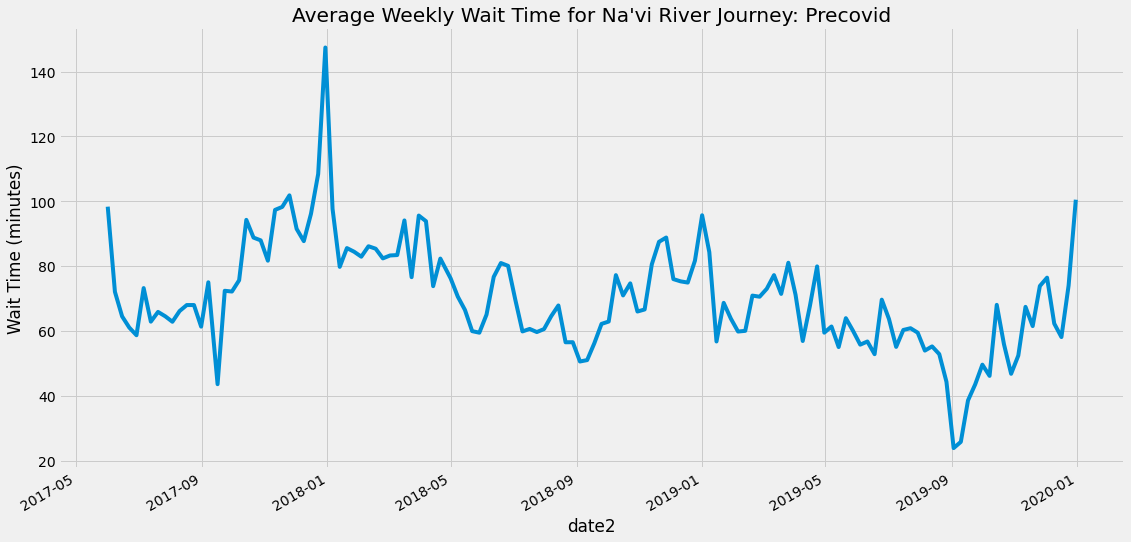

In [25]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Na'vi River Journey: Precovid")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is definite weekly fluctuation, but it doesn't appear to form a clear pattern.  The major spike at December, 2017 is due to higher park attendance at Christmas. There are similar, though smaller, spikes in November and December, 2018.  In Florida, summer vacation begins in mid-May and ends in early to mid-August.  The smaller spikes in late May, 2018 and 2019 likely are due to summer vacation for local schoolchildren.

# Modeling

## Null Model

In [26]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

70.21449434910376

In this case, the null model is the mean wait time before covid, or 70 minutes.  I calculated this figure using the original data but excluding all dates after March 15, 2020.

##  Weekly ACF and PACF Plots

In [27]:
precovid_weekly.shape

(135, 9)

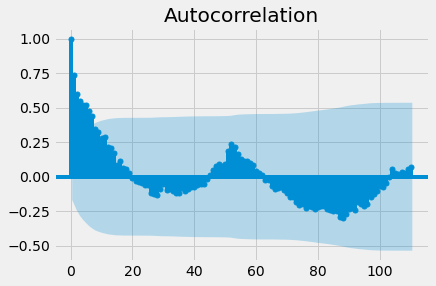

In [28]:
# Weekly ACF plot for May 26, 2017 - July, 15, 2019: pre-covid
plot_acf(precovid_weekly['avg_weekly_wait'], lags=110)
plt.show()

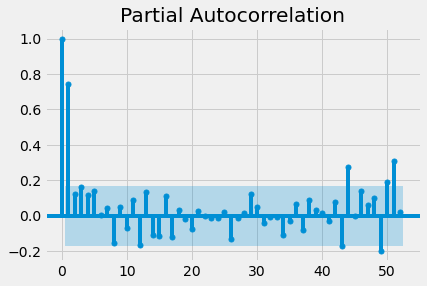

In [29]:
# Weekly PACF plot for May 26, 2017 - Dec 31, 2018: pre-covid
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=52)
plt.show()

This plot shows definite seasonality over the course of one year.  Aside from the initial spikes when the ride first opened, there is correlation approximately one year later (which corresponds with Florida schools getting out for summer vacation), as well as a spike around spring break.  The negative partial autocorrelations are trickier to explain, but at a glance I'd guess those are weeks shortly before or after school vacations.

### 90 Day ACF and PACF Plots

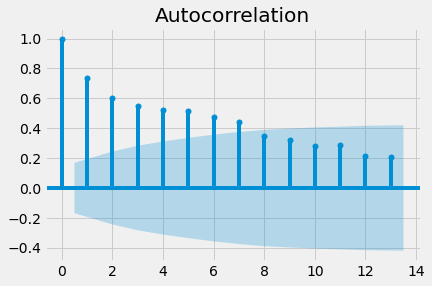

In [30]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_acf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

Autocorrelation remains high for about 6 weeks.  This is enough to help local Disney guests, but might be less useful for those who must book flights to Disney.

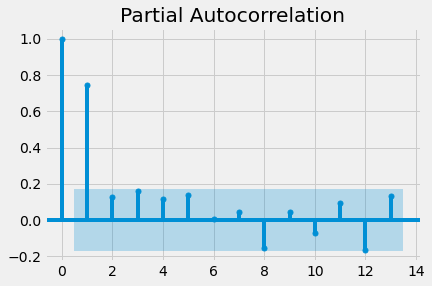

In [31]:
# 13 Week plot beginning May 26, 2017 (roughly 3 months)
plot_pacf(precovid_weekly['avg_weekly_wait'], lags=13)
plt.show()

Partial autocorrelation over three months is negligible, aside from the first two weeks.

In [32]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])
precovid_weekly_3

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2017-06-01,98.343502
2017-06-08,72.110169
2017-06-15,64.533198
2017-06-22,61.076240
2017-06-29,58.719537
...,...
2019-11-28,74.624324
2019-12-05,72.416089
2019-12-12,61.118936


In [33]:
precovid_weekly_3.min()

avg_weekly_wait    23.935373
dtype: float64

In [34]:
#model = pmd.auto_arima(precovid_weekly_3['avg_weekly_wait'], m=52, trace=True)

In [35]:
sarimax_model = sm.tsa.statespace.SARIMAX(precovid_weekly_3['avg_weekly_wait'], order=(0,1,2), seasonal_order=(2, 0, 0, 52))
navi_results = sarimax_model.fit()

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77376D+00    |proj g|=  1.37871D-01


 This problem is unconstrained.



At iterate    5    f=  3.72778D+00    |proj g|=  1.47532D-02

At iterate   10    f=  3.72258D+00    |proj g|=  2.61949D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   1.252D-07   3.723D+00
  F =   3.7225783055851860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [36]:
# To eliminate any doubt, here's an adfuller test:
adfuller(precovid_weekly_3['avg_weekly_wait'])

(-4.250950513273451,
 0.0005395903139643974,
 0,
 134,
 {'1%': -3.480118600110386,
  '5%': -2.8833618426136196,
  '10%': -2.578407034974382},
 927.8361554026569)

With an alpha of .05 and a p-value of .0005, the data are allegedly stationary.  This is likely because on most days, the wait spikes shortly after the park opens and doesn't drop until shortly before the park closes.

In [37]:
print(f'Mean absolute error: {navi_results.mae}')
print(f'Mean squared error: {navi_results.mse}')

Mean absolute error: 8.830309558842744
Mean squared error: 181.0411797276292


Both mean absolute error and mean squared error are low.  This indicates that the model is strong, perhaps because of the high degree of autocorrelation.

In [38]:
print(navi_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     avg_weekly_wait   No. Observations:                  135
Model:             SARIMAX(0, 1, 2)x(2, 0, [], 52)   Log Likelihood                -502.548
Date:                             Mon, 25 Oct 2021   AIC                           1015.096
Time:                                     06:55:03   BIC                           1029.585
Sample:                                          0   HQIC                          1020.984
                                             - 135                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4278      0.060     -7.088      0.000      -0.546      -0.309
ma.L2         -0.2134      

# Pickle

In [39]:
with open('models/navi_results.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(navi_results, pickle_out)

## Predict Wait Times

Remember, the null model is that guests will wait 70 minutes to ride this ride.

In [40]:
covid_weekly['month'] = pd.DatetimeIndex(covid_weekly['date2']).month

In [41]:
covid_weekly_3 = covid_weekly[['avg_weekly_wait']]
covid_weekly_3.head()

,avg_weekly_wait
date,
2019-07-22,17.857143
2019-07-29,18.571429
2019-08-05,27.857143
2019-08-12,13.571429
2019-08-19,12.857143


In [42]:
# Predictions
start_index = 0
end_index = len(covid_weekly_3)
forecast = navi_results.predict(start=start_index, end=end_index)
forecast

date2
2017-06-01      0.000000
2017-06-08     98.339601
2017-06-15     79.291919
2017-06-22     74.218969
2017-06-29     68.967589
2017-07-06     65.561285
2017-07-13     72.163322
2017-07-20     65.201220
2017-07-27     67.566175
2017-08-03     65.693731
2017-08-10     64.715426
2017-08-17     66.151680
2017-08-24     66.909069
2017-08-31     67.150172
2017-09-07     63.601332
2017-09-16     71.377748
2017-09-23     53.061025
2017-09-30     70.057448
2017-10-07     67.146447
2017-10-14     71.570018
2017-10-21     82.747617
2017-10-28     81.371947
2017-11-04     83.847457
2017-11-11     81.207500
2017-11-18     90.905862
2017-11-25     91.674197
2017-12-02     95.914365
2017-12-09     91.223751
2017-12-16     90.159057
2017-12-23     94.343571
2017-12-30    101.119270
2018-01-06    124.597449
2018-01-13     99.305695
2018-01-20     93.886702
2018-01-27     93.295641
2018-02-03     90.010451
2018-02-10     87.843579
2018-02-17     88.381802
2018-02-24     87.029876
2018-03-03     85.0

In [43]:
predictions = pd.DataFrame(forecast)
predictions.head()

,predicted_mean
date2,
2017-06-01,0.000000
2017-06-08,98.339601
2017-06-15,79.291919
2017-06-22,74.218969
2017-06-29,68.967589


In [44]:
df_final = precovid_weekly_3.merge(predictions, left_on='date2', right_on='date2')

In [45]:
df_final.head()

,avg_weekly_wait,predicted_mean
date2,,
2017-06-01,98.343502,0.000000
2017-06-08,72.110169,98.339601
2017-06-15,64.533198,79.291919
2017-06-22,61.076240,74.218969
2017-06-29,58.719537,68.967589


In [46]:
df_final['resids'] = df_final['predicted_mean'] - df_final['avg_weekly_wait']

In [47]:
df_final.mean()

avg_weekly_wait    79.841321
predicted_mean     78.884104
resids             -0.957216
dtype: float64

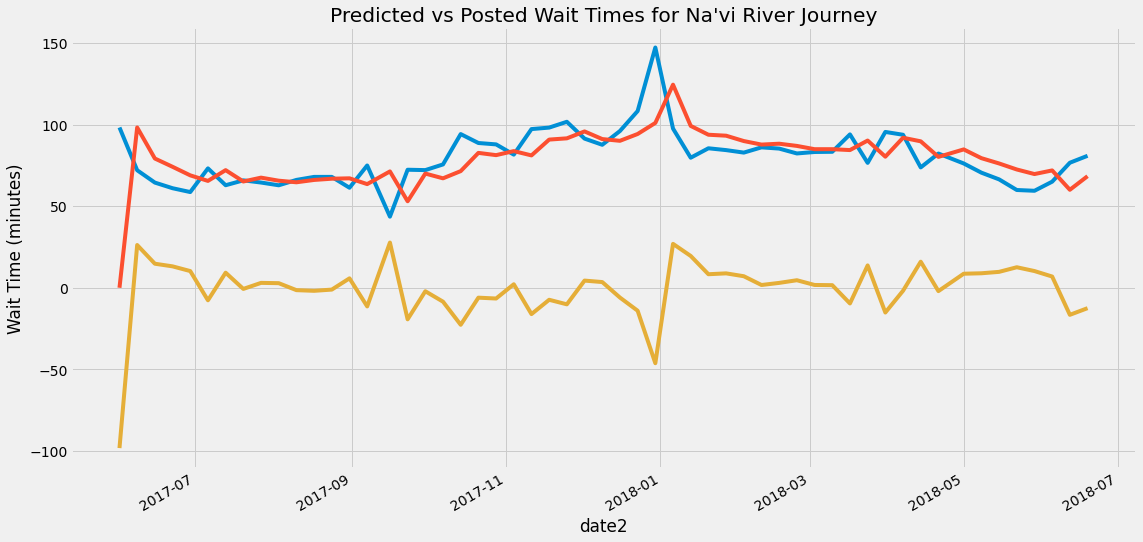

In [48]:
plt.figure(figsize = (17, 9))
plt.title("Predicted vs Posted Wait Times for Na'vi River Journey")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')

df_final['avg_weekly_wait'].plot()
df_final['predicted_mean'].plot()
df_final['resids'].plot()
plt.legend;

In [49]:
covid_weekly_3.to_csv('data/navi_covid_weekly3.csv', index=True)